##### Copyright 2025 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/core/huggingface_text_full_finetune"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb""><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb"><img src="https://www.kaggle.com/static/images/logos/kaggle-logo-transparent-300.png" height="32" width="70"/>Run in Kaggle</a>
  </td>
  <td>
    <a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/google/generative-ai-docs/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb"><img src="https://ai.google.dev/images/cloud-icon.svg" width="40" />Open in Vertex AI</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Full Model Fine-Tune using Hugging Face Transformers

This guide walks you through how to fine-tune Gemma on a mobile game NPC dataset using Hugging Face [Transformers](https://huggingface.co/docs/transformers/index) and [TRL](https://huggingface.co/docs/trl/index). You will learn:

- Setup development environment
- Prepare the fine-tuning dataset
- Full model fine-tuning Gemma using TRL and the SFTTrainer
- Test Model Inference and vibe checks

> Note: This guide was created to run on a Google colaboratory account using a NVIDIA T4 GPU with 16GB and Gemma 270m, but can be adapted to run on bigger GPUs and bigger models.

## Setup development environment

The first step is to install Hugging Face Libraries, including TRL, and datasets to fine-tune open model, including different RLHF and alignment techniques.

In [2]:
# Install Pytorch & other libraries
%pip install torch tensorboard

# Install Hugging Face libraries
%pip install transformers datasets accelerate evaluate trl protobuf sentencepiece

# COMMENT IN: if you are running on a GPU that supports BF16 data type and flash attn, such as NVIDIA L4 or NVIDIA A100
#% pip install flash-attn
%pip install bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

> _Note: If you are using a GPU with Ampere architecture (such as NVIDIA L4) or newer, you can use Flash attention. Flash Attention is a method that significantly speeds computations up and reduces memory usage from quadratic to linear in sequence length, leading to acelerating training up to 3x. Learn more at [FlashAttention](https://github.com/Dao-AILab/flash-attention/tree/main)._

Before you can start training, you have to make sure that you accepted the terms of use for Gemma. You can accept the license on [Hugging Face](http://huggingface.co/google/gemma-3-270m-it) by clicking on the Agree and access repository button on the model page at: http://huggingface.co/google/gemma-3-270m-it

After you have accepted the license, you need a valid Hugging Face Token to access the model. If you are running inside a Google Colab, you can securely use your Hugging Face Token using the Colab secrets otherwise you can set the token as directly in the `login` method. Make sure your token has write access too, as you push your model to the Hub during training.

In [3]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN') # If you are running inside a Google Colab
login(hf_token)

You can keep the results on Colab's local virtual machine. However, we highly recommend saving your intermediate results to your Google Drive. This ensures your training results are safe and allows you to easily compare and select the best model.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Select the base model to fine-tune, adjust the checkpoint directory and the learning rate.

In [5]:
base_model = "google/gemma-3-270m-it" # @param ["google/gemma-3-270m-it","google/gemma-3-1b-it","google/gemma-3-4b-it","google/gemma-3-12b-it","google/gemma-3-27b-it"] {"allow-input":true}
checkpoint_dir = "/content/drive/MyDrive/MyEntireGemmaPython" #@param {type:"string"}
learning_rate = 2e-5 #@param {type:"number"}

## Create and prepare the fine-tuning dataset

The [bebechien/MobileGameNPC](https://huggingface.co/datasets/bebechien/MobileGameNPC) dataset provides a small sample conversations between a player and two Alien NPCs (a Martian and a Venusian), each with a unique speaking style. For instance, the Martian NPC speaks with an accent that replaces 's' sounds with 'z', uses 'da' for 'the', 'diz' for 'this', and includes occasional clicks like `*k'tak*`.

This dataset demonstrates a key principle for fine-tuning: the required dataset size depends on the desired output.

- To teach the model a stylistic variation of a language it already knows, such as the Martian's accent, a small dataset with as few as 10 to 20 examples can be sufficient.
- However, to teach the model a completely new or mixed alien language, a significantly larger dataset would be required.

In [6]:
from datasets import load_dataset

def create_conversation(sample):
    # Merge any system guidance into the first user turn
    merged_prompt = (
        sample.get("system", "").strip() + "\n\n" + sample["instruction"]
        if sample.get("system") else sample["instruction"]
    )
    return {
        "messages": [
            {"role": "user",      "content": merged_prompt.strip()},
            {"role": "assistant", "content": sample["output"]},
        ]
    }

dataset = load_dataset("jtatman/python-code-dataset-500k",
                       split="train")           # columns: instruction / output / system[41]
if len(dataset) > 560000:
  dataset = dataset.select(range(560000))

dataset = dataset.map(create_conversation,
                      remove_columns=list(dataset.features),
                      batched=False)

dataset = dataset.train_test_split(test_size=0.01, shuffle=False)

print(dataset["train"][0]["messages"])

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/559515 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

[{'content': 'You are a Python code analyst, evaluating scripts for potential improvements.\n\nCreate a nested loop to print every combination of numbers between 0-9, excluding any combination that contains the number 5. Additionally, exclude any combination that contains a repeating digit. Implement the solution without using any built-in functions or libraries to check for repeating digits.', 'role': 'user'}, {'content': 'Here is an example of a nested loop in Python to print every combination of numbers between 0-9, excluding any combination that contains the number 5 or repeating digits:\n\n```python\nfor i in range(10):  # First digit\n    for j in range(10):  # Second digit\n        for k in range(10):  # Third digit\n            # Checking for the conditions\n            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:\n                print(i, j, k)\n```\n\nThis code will generate and print every combination of three digits between 0-9 that do not contain the n

## Fine-tune Gemma using TRL and the SFTTrainer

You are now ready to fine-tune your model. Hugging Face TRL [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) makes it straightforward to supervise fine-tune open LLMs. The `SFTTrainer` is a subclass of the `Trainer` from the `transformers` library and supports all the same features,

The following code loads the Gemma model and tokenizer from Hugging Face.

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# 4-bit quantization for T4 GPU memory optimization
quantization_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_compute_dtype=torch.bfloat16,
  bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
  base_model,
  quantization_config=quantization_config,
  device_map="auto",
  torch_dtype=torch.bfloat16,
  attn_implementation="eager"  # Keep this for T4
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


## Before fine-tune

The output below shows that the out-of-the-box capabilities may not be good enough for this use case.

In [8]:
from transformers import pipeline

from random import randint
import re

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Load a random sample from the test dataset
rand_idx = randint(0, len(dataset["test"])-1)
test_sample = dataset["test"][rand_idx]

# Convert as test example into a prompt with the Gemma template
prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

# Extract the user query and original answer
print(f"Question:\n{test_sample['messages'][0]['content']}\n")
print(f"Original Answer:\n{test_sample['messages'][1]['content']}\n")
print(f"Generated Answer (base model):\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Device set to use cuda:0


Question:
You are a Python code analyst, evaluating scripts for potential improvements.

Write a Python program to concatenate all elements in a list into a string separated by a given separator. The separator must be a non-alphanumeric character. If the separator is not provided, the default separator should be a hyphen ("-").

Additionally, if the input list contains any nested lists, the program should recursively flatten the list and concatenate all elements.

Example:
Input:
input_list = ["Python", "is", "a", "programming", "language"]
separator = ""

Output:
Pythonisaprogramminglanguage

Input:
input_list = ["Python", ["is", "a"], "programming", ["language"]]
separator = ""

Output:
Pythonisaprogramminglanguage

Input:
input_list = ["Python", "is", "a", "programming", "language"]
separator = "-"

Output:
Python-is-a-programming-language

Input:
input_list = ["Python", ["is", "a"], "programming", ["language"]]
separator = "-"

Output:
Python-is-a-programming-language

Original Ans

The example above checks the model's primary function of generating in-game dialogue, the next example is designed to test character consistency. We challenge the model with an off-topic prompt. For instance, `Sorry, you are a game NPC.`, that falls outside the character's knowledge base.

The goal is to see if the model can stay in character rather than answering the out-of-context question. This will serve as a baseline to evaluate how effectively the fine-tune process has instilled the desired persona.

In [9]:
outputs = pipe([{"role": "user", "content": "Write a Python function to check if a number is prime."}], max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'][1]['content'])

```python
def is_prime(number):
    """
    Checks if a number is prime.

    Args:
        number: The number to check.

    Returns:
        True if the number is prime, False otherwise.
    """
    if number <= 1:
        return False  # Numbers less than 2 are not prime
    if number <= 3:
        return True  # 1 and 3 are prime
    if number % 2 == 0:
        return False  # If even, it's not prime
    for i in range(3, int(number**0.5) + 1):
        if number % i == 0:
            return False  # If divisible by any number, it's not prime
    return True  # If all numbers are prime, it's prime
```

**Explanation:**

1. **Base Cases:**
   - If the number is less than or equal to 1, it's not prime.
   - If the number is 2 or 3, it's prime.

2. **Iterating through Numbers:**
   - We loop through numbers from 


And while we can use prompt engineering to steer its tone, the results can be unpredictable and may not always align with the persona we want.

In [10]:
message = [
    # give persona
    {"role": "system", "content": "You are a Python coding assistant. Explain code clearly, follow PEP-8 style, and add comments."},
]

# few shot prompt
for item in dataset['test']:
  message.append(
      {"role": "user", "content": item["messages"][0]["content"]}
  )
  message.append(
      {"role": "assistant", "content": item["messages"][1]["content"]}
  )

# actual question
message.append(
    {"role": "user", "content": "How do I reverse a list in place in Python without using slicing?"}
)

outputs = pipe(message, max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'])
print("-"*80)
print(outputs[0]['generated_text'][-1]['content'])


[{'role': 'system', 'content': 'You are a Python coding assistant. Explain code clearly, follow PEP-8 style, and add comments.'}, {'role': 'user', 'content': 'You are a Python code analyst, evaluating scripts for potential improvements.\n\nImplement a modified version of the quick-sort algorithm in Python that can handle duplicate elements and sorts the array in descending order, while also keeping track of the number of comparisons made during the sorting process. In addition, introduce a bug in the code that causes incorrect sorting for arrays with an odd number of elements.\n\nFurthermore, modify the algorithm to handle arrays with negative numbers as well. The algorithm should sort the array in descending order, with negative numbers appearing before positive numbers.\n\nLastly, introduce another bug in the code that causes incorrect sorting for arrays with duplicate elements.'}, {'role': 'assistant', 'content': 'Here is an implementation of the modified quick-sort algorithm that c

In [ ]:
# Auto-resume detection
import os
import glob

def find_latest_checkpoint(checkpoint_dir):
  pattern = os.path.join(checkpoint_dir, "checkpoint-*")
  checkpoints = glob.glob(pattern)
  if not checkpoints:
    print("No checkpoints found - starting fresh")
    return None

  latest = max(checkpoints, key=lambda x: int(x.split('-')[-1]))
  step = latest.split('-')[-1]
  print(f"Found checkpoint at step {step}: {latest}")
  return latest

resume_checkpoint = find_latest_checkpoint(checkpoint_dir)

## Training

Before you can start your training, you need to define the hyperparameters you want to use in a `SFTConfig` instance.

In [11]:
from trl import SFTConfig

torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    resume_from_checkpoint=resume_checkpoint,
    dataloader_pin_memory=False,
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=1,                     # number of training epochs
    per_device_train_batch_size=1,          # batch size per device during training
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=1,
    gradient_checkpointing=True,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=500,                        # log every step
    save_strategy="steps",                  # save checkpoint every epoch
    save_steps=1000,
    save_total_limit=2,
    eval_strategy="steps",                  # evaluate checkpoint every epoch
    eval_steps=5000,
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,
    bf16=True if torch_dtype == torch.bfloat16 else False,
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False, # Template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    },
    dataloader_num_workers=0,
    remove_unused_columns=False,
)

You now have every building block you need to create your `SFTTrainer` to start the training of your model.

In [12]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
)

Tokenizing train dataset:   0%|          | 0/40 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/40 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/10 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/10 [00:00<?, ? examples/s]

Start training by calling the `train()` method.

In [13]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

Epoch,Training Loss,Validation Loss
1,0.827500,1.042369
2,0.558400,1.051049
3,0.360400,1.230991
4,0.232300,1.449164
5,0.124000,1.596604


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ive/MyGemmaPython/training_args.bin: 100%|##########| 5.82kB / 5.82kB            

  ...vents.1755281733.8b402512d0e5.362.0: 100%|##########| 24.7kB / 24.7kB            

  ...yDrive/MyGemmaPython/tokenizer.json:  25%|##4       | 8.28MB / 33.4MB            

  ...Drive/MyGemmaPython/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...ive/MyGemmaPython/model.safetensors:   2%|1         | 8.34MB /  536MB            

To plot the training and validation losses, you would typically extract these values from the `TrainerState` object or the logs generated during training.

Libraries like Matplotlib can then be used to visualize these values over training steps or epochs. The x-asis would represent the training steps or epochs, and the y-axis would represent the corresponding loss values.

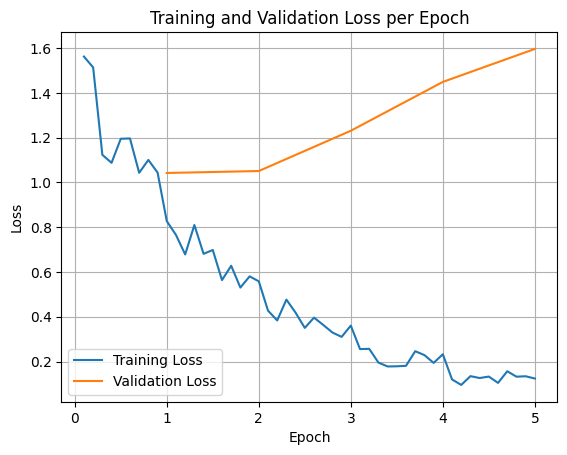

In [14]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

This visualization helps in monitoring the training process and making informed decisions about hyperparameters tuning or early stopping.

Training loss measures the error on the data the model was trained on, while validation loss measures the error on a separate dataset the model has not seen before. Monitoring both helps detect overfitting (when the model performs well on training data but poorly on unseen data).

- validation loss >> training loss: **overfitting**
- validation loss > training loss: **some overfitting**
- validation loss < training loss: **some underfitting**
- validation loss << training loss: **underfitting**

## Test Model Inference

After the training is done, you'll want to evaluate and test your model. You can load different samples from the test dataset and evaluate the model on those samples.

For this particular use case, the best model is a matter of preference. Interestingly, what we'd normally call 'overfitting' can be very useful for a game NPC. It forces the model to forget general information and instead lock onto the specific persona and characteristics it was trained on, ensuring it stays consistently in character.


In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = checkpoint_dir

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Let's load all questions from the test dataset and generate outputs.

In [16]:
from transformers import pipeline

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

def test(test_sample):
  # Convert as test example into a prompt with the Gemma template
  prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
  outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

  # Extract the user query and original answer
  print(f"Question:\n{test_sample['messages'][0]['content']}")
  print(f"Original Answer:\n{test_sample['messages'][1]['content']}")
  print(f"Generated Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")
  print("-"*80)

# Test with an unseen dataset
for item in dataset['test']:
  test(item)

Device set to use cuda:0


Question:
You are a Python code analyst, evaluating scripts for potential improvements.

Implement a modified version of the quick-sort algorithm in Python that can handle duplicate elements and sorts the array in descending order, while also keeping track of the number of comparisons made during the sorting process. In addition, introduce a bug in the code that causes incorrect sorting for arrays with an odd number of elements.

Furthermore, modify the algorithm to handle arrays with negative numbers as well. The algorithm should sort the array in descending order, with negative numbers appearing before positive numbers.

Lastly, introduce another bug in the code that causes incorrect sorting for arrays with duplicate elements.
Original Answer:
Here is an implementation of the modified quick-sort algorithm that can handle duplicate elements and sorts the array in descending order while keeping track of the number of comparisons made during the sorting process. The code also introduces

If you try our original generalist prompt, you can see that the model still attempts to answer in the trained style. In this example overfitting and catastrophic forgetting are actually beneficial for the game NPC because it will begin forgetting general knowledge which might not be applicable. This is also true for other types of full fine-tuning where the goal is to restrict the output to specific data formats.

In [18]:
outputs = pipe([{"role": "user", "content": "Create a function in Python which takes two parameters, a and b, and returns their product. However, the function should raise a ValueError if either of the parameters is not a positive integer. Additionally, the function should only allow inputs within a specified range of 1 to 1000 (inclusive) for both parameters. The function should also check if the product of the two parameters is a prime number and raise a custom exception named NotPrimeError if it is not."}], max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'][1]['content'])

Here is a Python function that takes two parameters, a and b, and returns their product:

```python
import math

def multiply(a, b):
    # Check if a is a positive integer
    if not isinstance(a, int) or not isinstance(b, int):
        raise ValueError("Invalid input. Please enter a and b as positive integers")

    # Check if b is a positive integer
    if not isinstance(b, int) or not isinstance(a, int):
        raise ValueError("Invalid input. Please enter b as a and b as positive integers")

    # Check if the product is prime
    if math.isprime(a):
        return a * math.isprime(b)
    else:
        return -1

# Example usage
a = 5
b = 3
result = multiply(a, b)
print(result)  # Expected output: 12
```

This code defines a function `multiply` that takes two parameters `a` and `b` and returns their product. It first checks if `a` is a positive integer using `isinstance(a, int)` and if `b` is an integer


## Summary and next steps

This tutorial covered how to full model fine-tune using TRL. Check out the following docs next:

* Learn how to [fine-tune Gemma for text tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_text_finetune_qlora).
* Learn how to [fine-tune Gemma for vision tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora).
* Learn how to [deploy to Cloud Run](https://ai.google.dev/gemma/docs/integrations/google-cloud#run)